In [234]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from multi_class_unet import multi_unet_model

## Loading Dataset

In [78]:
images_ls = []
masks_ls = []

classes = ['benign', 'malignant', 'normal']

x_size = 128 
y_size = 128

for c in classes:
    for filename in glob.glob(f'Dataset_kaggle\\{c}\\*.png'):
        if 'mask' not in filename:
            img = cv2.imread(filename, 0)
            img = cv2.resize(img, (y_size, x_size))
            images_ls.append(img)
        if 'mask.' in filename:
            img = cv2.imread(filename, 0)
            img = cv2.resize(img, (y_size, x_size), interpolation = cv2.INTER_NEAREST)
            if c == 'benign':
                img[img==255] = 1
            if c == 'malignant':
                img[img==255] = 2
            masks_ls.append(img)

print(len(images_ls))
print(len(masks_ls))

780
780


In [79]:
images = np.array(images_ls)
masks = np.array(masks_ls)

In [81]:
print(images.shape)
print(masks.shape)

(780, 128, 128)
(780, 128, 128)


In [88]:
print(np.unique(masks))

[0 1 2]


## Preparing Dataset

In [85]:
labelencoder = LabelEncoder()
n, h, w = masks.shape
masks_reshaped = masks.reshape(-1,1)
masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

In [90]:
print(masks_encoded_original_shape.shape)
print(np.unique(masks_encoded_original_shape))

(780, 128, 128)
[0 1 2]


In [95]:
proc_images = np.expand_dims(images, axis=3)
proc_images = normalize(proc_images, axis=1)

proc_masks = np.expand_dims(masks_encoded_original_shape, axis=3)

print(proc_images.shape)
print(proc_masks.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [96]:
X_train, X_test, y_train, y_test = train_test_split(proc_images, proc_masks, test_size = 0.1, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2]


In [104]:
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

print(y_train_cat.shape)
print(y_test_cat.shape)

(702, 128, 128, 3)
(78, 128, 128, 3)


## Training Model

In [107]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(masks_reshaped_encoded),
                                                 y = masks_reshaped_encoded)
print(f"Class weights are...: {class_weights}")

Class weights are...: [0.36121167 8.87701538 8.41115922]


In [109]:
# Took me around 51 minutes to train

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=len(classes), IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    
model.save('model_test.hdf5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## Loading Model

In [ ]:
model.load_weights('model_test.hdf5')  

## Evaluating Model

In [110]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 [==============================] - 1s 397ms/step - loss: 0.1815 - accuracy: 0.9535
Accuracy is =  95.35068869590759 %


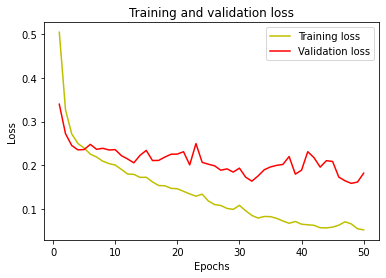

In [111]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

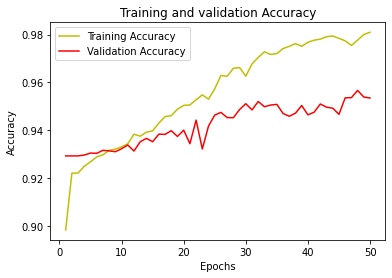

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [115]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

Intersection Over Union (IOU)

In [117]:
IOU_keras = MeanIoU(num_classes=len(classes))  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.61691815


In [119]:
values = np.array(IOU_keras.get_weights()).reshape(len(classes), len(classes))
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

[[1166788.    9149.   11699.]
 [   7238.   24291.    5698.]
 [  23791.    1841.   27457.]]
IoU for class1 is:  0.9574313
IoU for class2 is:  0.50378495
IoU for class3 is:  0.38953835


In [232]:
y_test_lbl = [int(np.max(y_test[x])) for x in range(len(y_test))]
y_pred_lbl = [int(np.max(y_pred_argmax[x])) for x in range(len(y_pred_argmax))]

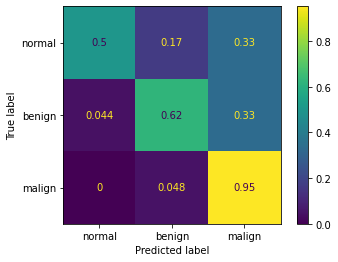

In [237]:
cm = confusion_matrix(y_test_lbl, y_pred_lbl, normalize= 'true')
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','benign', 'malign'])
cmd.plot()

In [238]:
print(classification_report(y_test_lbl, y_pred_lbl, target_names=['normal','benign', 'malign']))

              precision    recall  f1-score   support

      normal       0.75      0.50      0.60        12
      benign       0.90      0.62      0.74        45
      malign       0.51      0.95      0.67        21

    accuracy                           0.69        78
   macro avg       0.72      0.69      0.67        78
weighted avg       0.77      0.69      0.70        78



## Predicting Images

In [180]:
np.random.randint(0, 100, 5)

array([11, 28, 11, 62, 58])

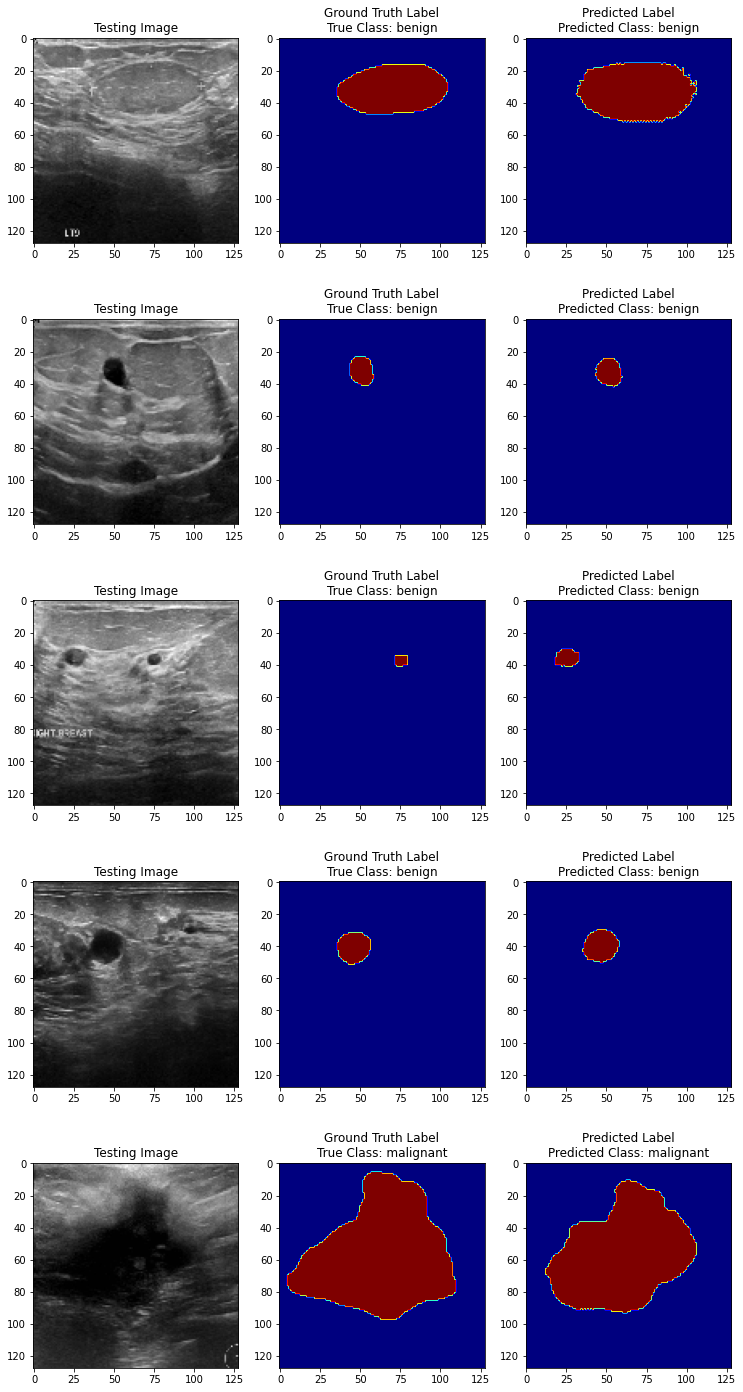

<Figure size 432x288 with 0 Axes>

In [194]:
def prep_img(img):
    prep_img = img.copy()
    prep_img[prep_img == 1] = 127
    prep_img[prep_img == 2] = 255
    return prep_img

labels = ['normal', 'benign', 'malignant']
n_test = 5
test_img_numbers = np.random.randint(0, len(X_test), n_test)

plt.figure(figsize=(n_test*2.5, n_test*5))

for i,test_img_number in enumerate(test_img_numbers):
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    true_class = np.max(np.unique(ground_truth))
    predicted_class = np.max(np.unique(predicted_img))

    pred_img = prep_img(predicted_img)
    true_img = prep_img(ground_truth)

    plt.subplot(n_test,3,i*3+1)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(n_test,3,i*3+2)
    plt.title(f'Ground Truth Label\nTrue Class: {labels[true_class]}')
    plt.imshow(true_img[:,:,0], cmap='jet')
    plt.subplot(n_test,3,i*3+3)
    plt.title(f'Predicted Label\nPredicted Class: {labels[predicted_class]}')
    plt.imshow(pred_img, cmap='jet')

plt.show()
plt.tight_layout()